In [1]:
import numpy as np
import pims
from lib import detection
from lib import analysis
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import stats
from scipy import signal
from skimage import feature
import math

import rpy2
from rpy2.robjects import numpy2ri
numpy2ri.activate()

import seaborn as sns
import pandas as pd

In [38]:
def report_performance(events, puff_idsmovie_subsets):
    num_puffs = np.shape(np.array(markers))[0]
    detected_puffs = np.sum(puff_ids>0)
    unique_puffs = len(np.unique(puff_ids[puff_ids>0]))
    num_events = len(np.unique(events['particle']))
    puff_freq = unique_puffs/num_events
    print('%d/%d puffs (%d unique) in %d events (%.5f freq)' % 
          (detected_puffs, num_puffs, unique_puffs, num_events, puff_freq))

def gauss_laplace_fa(frame, sigma):
    window = math.ceil(4*sigma)
    fg = ndimage.gaussian_filter(frame, sigma)
    extended_frame = np.pad(frame, window, mode='reflect')

    x = np.arange(-window, window+1)
    gauss_1d = np.exp(-np.power(x,2)/(2.*sigma**2.))
    gx2 = gauss_1d*x**2
    
    imgLoG = (2*fg/sigma**2 - 
              (signal.convolve2d(gauss_1d*gx2.reshape(-1,1), extended_frame, 'valid') +
               signal.convolve2d(gx2*gauss_1d.reshape(-1,1), extended_frame, 'valid'))/sigma**4)
    imgLoG = imgLoG / (2*math.pi*sigma**2)
    return imgLoG

def gauss_laplace_scipy(frame, sigma):
    fg = ndimage.gaussian_filter(frame, sigma)
    imgLoG = ndimage.gaussian_laplace(fg, sigma)
    return imgLoG

In [2]:
movie = pims.TiffStack('data/videos/OPP/0IYVHRNA.tif')
markers = detection.import_xml_data('data/videos/OPP/0IYVHRNA-ZYW-1.xml')
markers_subset = [marker for marker in markers if marker[2] in range(1975,2275)]
markers_subset = [[marker[0], marker[1], marker[2]-1975] for marker in markers_subset]
movie_subset = movie[1974:2274]

mask = detection.get_mask(movie_subset)
masked_subset = movie_subset * mask

sigma = 1.26

/Volumes/Coatamer/Users/weinberz/Google Drive/Code/puffapy/lib/detection.py:219: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  (linear_blurred < percentiles[1])])


In [3]:
averaged_subset = ndimage.uniform_filter(movie_subset[:], size=(5,0,0))

(-0.5, 299.5, 299.5, -0.5)

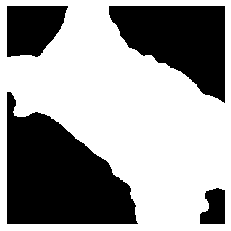

In [24]:
plt.imshow(mask, cmap='gray')
plt.axis('off')

(-0.5, 299.5, 299.5, -0.5)

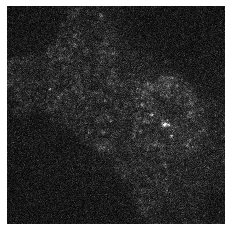

In [14]:
plt.imshow(movie_subset[0], vmin=np.amin(movie_subset[0][:,:]), vmax=2000,cmap='gray')
plt.axis('off')

(-0.5, 299.5, 299.5, -0.5)

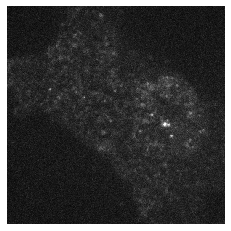

In [17]:
plt.imshow(averaged_subset[0], vmin=np.amin(movie_subset[0][:,:]), vmax=2000,cmap='gray')
plt.axis('off')

(-0.5, 299.5, 299.5, -0.5)

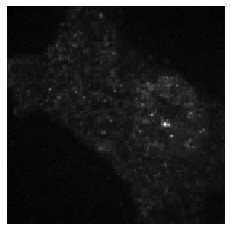

In [22]:
from skimage.restoration import denoise_wavelet
frame = denoise_wavelet(averaged_subset[0], multichannel=False)
plt.imshow(frame, vmin=np.amin(frame), vmax=0.8*np.amax(frame), cmap='gray')
plt.axis('off')

In [23]:
from scipy import ndimage
min_sigma = 1
max_sigma = 3
num_sigma = 11
scale = np.linspace(0, 1, num_sigma)[:, None]
sigma_list = scale * (max_sigma - min_sigma) + min_sigma
sigma_list = sigma_list[:,0]
gls = [-ndimage.filters.gaussian_laplace(frame, sig) * sig **2 for sig in sigma_list]

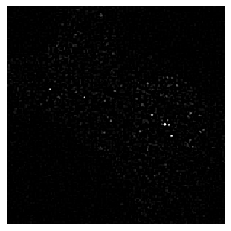

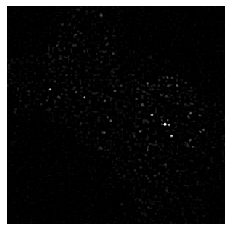

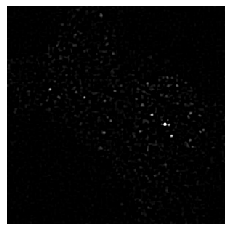

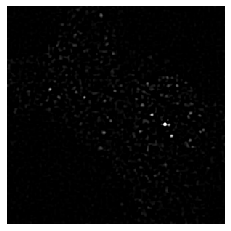

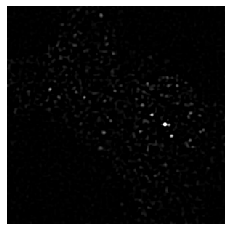

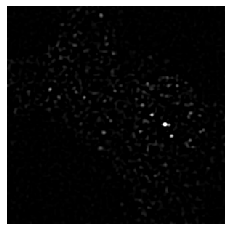

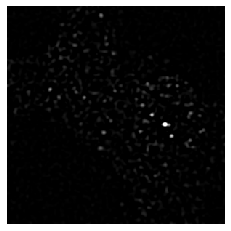

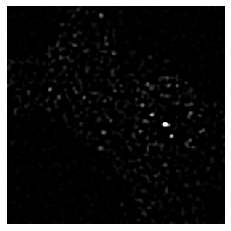

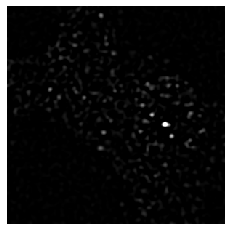

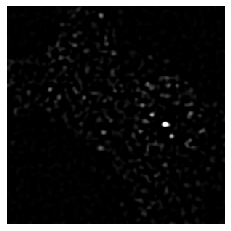

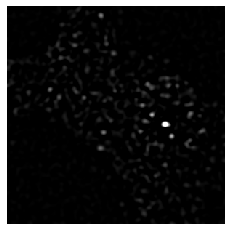

In [28]:
for img in gls:
    plt.figure()
    plt.imshow(img, vmin=0, vmax=0.5*np.amax(img), cmap='gray')
    plt.axis('off')
    plt.show()

In [29]:
background_frame, signif_mask, residuals, snr = detection.get_loc_background(averaged_subset[0])

In [31]:
from skimage.feature import peak_local_max

mask = mask * signif_mask

plm = [peak_local_max(x, indices=False) for x in gls]
plm = [np.transpose(np.nonzero(x & mask))[::-1] for x in plm]
plmval = np.concatenate([[gls[i][r, c] for (r, c) in plm[i]] for i in range(len(sigma_list))])
sigmas_of_peaks = np.concatenate([np.repeat(sigma_list[i], len(plm[i])) for i in range(len(sigma_list))])
plm = np.hstack([np.concatenate(plm), sigmas_of_peaks.reshape(len(sigmas_of_peaks), 1)])

loc_background = np.array([background_frame[int(loc_max[0]), int(loc_max[1])] for loc_max in plm])

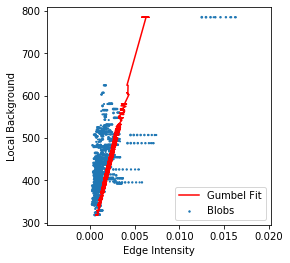

In [99]:
from scipy.stats import gumbel_r
fit_at= np.linspace(0,1,100)
thresh = gumbel_r.ppf(q=0.9, loc=coef[0] + coef[1]*sigmas_of_peaks + coef[2]*loc_background + coef[3]*sigmas_of_peaks*loc_background,
                      scale=coef[4] +coef[5]*sigmas_of_peaks + coef[6]*loc_background + coef[7]*sigmas_of_peaks*loc_background)

plt.figure(figsize=(4,4))
plt.scatter(plmval, loc_background, s=sigmas_of_peaks, marker='o', label='Blobs')
plt.plot(thresh[np.argsort(loc_background)], loc_background[np.argsort(loc_background)], c='r', label='Gumbel Fit')
plt.xlabel('Edge Intensity')
plt.ylabel('Local Background')
plt.legend()
plt.show()

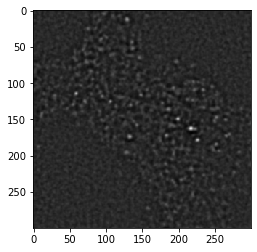

In [101]:
plt.imshow(snr, cmap='gray')

In [62]:
coef = detection.gev_glm(plmval, sigmas_of_peaks, loc_background)

In [93]:
from scipy.stats import gumbel_r
fit_at= np.linspace(0,1,100)
thresh = gumbel_r.ppf(q=0.9, loc=coef[0] + coef[1]*sigmas_of_peaks + coef[2]*loc_background + coef[3]*sigmas_of_peaks*loc_background,
                      scale=coef[4] +coef[5]*sigmas_of_peaks + coef[6]*loc_background + coef[7]*sigmas_of_peaks*loc_background)

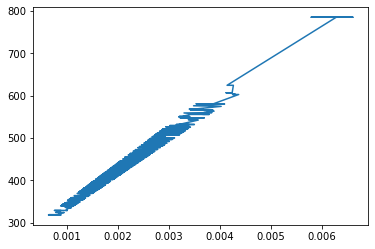

In [96]:
plt.plot(thresh[np.argsort(loc_background)], loc_background[np.argsort(loc_background)])

In [ ]:
import trackpy as tp
events = pd.read_csv('data/0IYVHRNA.tif_events.csv')
tp.plot_traj()

In [102]:
locs = detection.find_locs(averaged_subset)

/Volumes/Coatamer/Users/weinberz/Google Drive/Code/puffapy/lib/detection.py:219: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  (linear_blurred < percentiles[1])])


In [103]:
import trackpy as tp
events = tp.link_df(locs, search_range=1.5, memory=0)
events = tp.filter_stubs(events, 4)

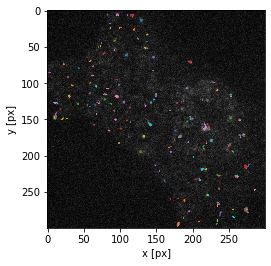

(0.0, 1.0, 0.0, 1.0)

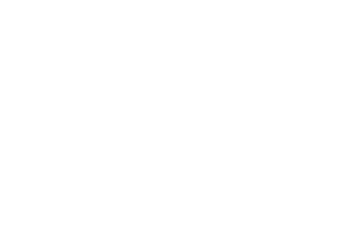

In [107]:
plt.figure()
ax = tp.plot_traj(events, superimpose=movie_subset[0])
plt.axis('off')

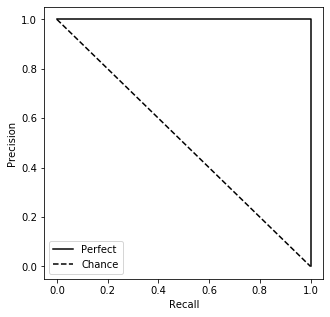

In [117]:
plt.figure(figsize=(5,5))
plt.plot([0, 1, 1], [1, 1, 0], c='k', label = 'Perfect')
plt.plot([0, 0.5, 1], [1, 0.5, 0], linestyle='--', c='k', label='Chance')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [72]:
intensities = detection.intensity_grid(movie_subset,events[['frame','x','y','particle']])

In [120]:
analysis.get_features_r(intensities)

cell,particle,conv_perim,...,cc23,deltaf,tau
1.000000,1,1.399161,...,0.056328,16.814815,0.020000
1.000000,3,1.580754,...,-0.073359,8.333333,0.000000
1.000000,4,1.219342,...,0.071889,15.705426,0.120000
1.000000,5,0.909720,...,-0.010833,6.619883,0.000000
...,...,...,...,...,...,...
1.000000,"1,313",1.402809,...,0.030070,8.396341,0.000000
1.000000,"1,317",0.595364,...,-0.008216,7.246305,0.000000
1.000000,"1,319",0.991006,...,0.010614,6.690058,0.020000
1.000000,"1,320",0.733394,...,0.009852,6.016216,0.020000


In [133]:
features = analysis.get_features(events, intensities)

In [140]:
puff_ids = np.array([detection.filter_df(events, m, 5) for m in markers_subset])
features.loc[:, 'puff'] = features['particle'].isin(puff_ids).astype(int)

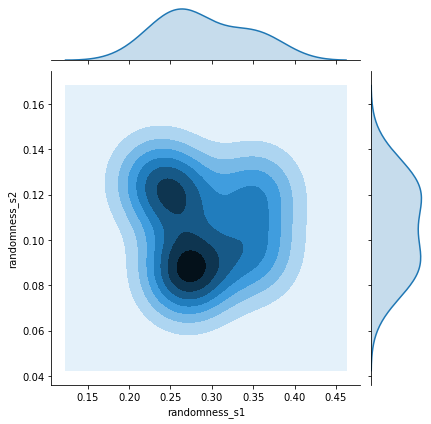

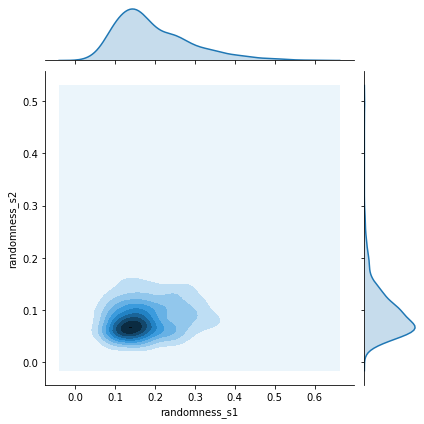

In [155]:
sns.jointplot(x=features.loc[features["puff"] == 1,"randomness_s1"], y=features.loc[features["puff"] == 1,"randomness_s2"], kind="kde")
sns.jointplot(x=features.loc[features["puff"] == 0,"randomness_s1"], y=features.loc[features["puff"] == 0,"randomness_s2"], kind="kde")

In [85]:
features = pd.read_csv('data/0IYVHRNA.tif_featuress.csv', index_col=False)

In [109]:
df = events[["particle", "residuals", "snr"]].groupby("particle").agg(['max','min','mean','median','std']).reset_index()
df.columns = ["_".join(x) for x in df.columns.ravel()]
df

,particle_,residuals_max,residuals_min,residuals_mean,residuals_std,residuals_median,snr_max,snr_min,snr_mean,snr_std,snr_median
0,1,127.279625,63.880023,95.747821,14.414305,96.835471,2.943415,1.162985,2.048107,0.355869,2.120679
1,3,73.244884,41.756552,49.379200,8.941387,46.554478,0.774111,0.478676,0.603481,0.099292,0.566323
2,4,94.641736,60.386451,74.756571,11.168658,71.695480,2.634593,0.885368,2.028441,0.555028,2.085241
3,5,90.927724,83.232768,86.081633,3.447967,85.083020,1.274690,0.855280,1.043680,0.182444,1.022376
4,6,106.641396,60.466875,80.891400,9.431178,80.865682,2.126391,1.103244,1.600553,0.208034,1.611177
5,7,78.403561,66.602854,70.361629,4.159097,67.922779,0.744020,0.553146,0.642410,0.067217,0.657208
6,8,371.329247,133.071449,280.068452,46.035196,283.927362,3.908360,1.349402,2.974082,0.551361,3.055352
7,9,126.659052,64.058051,87.230770,13.232162,84.469529,2.470506,0.988675,1.731904,0.327268,1.712039
8,10,102.120750,58.242585,76.285930,8.250301,75.423327,2.268006,1.121890,1.641629,0.234785,1.634953
9,11,144.659145,71.991922,93.414379,10.541546,92.130390,2.782311,1.772082,2.264680,0.198847,2.277346


In [108]:
df

,particle_,residuals_max,residuals_min,residuals_mean,residuals_std,snr_max,snr_min,snr_mean,snr_std
0,1,127.279625,63.880023,95.747821,14.414305,2.943415,1.162985,2.048107,0.355869
1,3,73.244884,41.756552,49.379200,8.941387,0.774111,0.478676,0.603481,0.099292
2,4,94.641736,60.386451,74.756571,11.168658,2.634593,0.885368,2.028441,0.555028
3,5,90.927724,83.232768,86.081633,3.447967,1.274690,0.855280,1.043680,0.182444
4,6,106.641396,60.466875,80.891400,9.431178,2.126391,1.103244,1.600553,0.208034
5,7,78.403561,66.602854,70.361629,4.159097,0.744020,0.553146,0.642410,0.067217
6,8,371.329247,133.071449,280.068452,46.035196,3.908360,1.349402,2.974082,0.551361
7,9,126.659052,64.058051,87.230770,13.232162,2.470506,0.988675,1.731904,0.327268
8,10,102.120750,58.242585,76.285930,8.250301,2.268006,1.121890,1.641629,0.234785
9,11,144.659145,71.991922,93.414379,10.541546,2.782311,1.772082,2.264680,0.198847


In [89]:
features_weird = features[["cell", "particle"]].copy()

In [96]:
features.merge(features_weird, on=["cell","particle"])

,Unnamed: 0,cell,particle,conv_perim,conv_area,lifetime_s,cc11,cc12,cc13,cc21,cc22,cc23,deltaf,tau,random
0,0,1.0,0.0,0.856790,0.011764,0.08,-0.046659,0.030501,-0.017931,-0.022686,0.060275,-0.013836,9.512563,0.00,851
1,1,1.0,1.0,1.191694,0.035371,0.24,-0.125145,0.031146,0.061533,-0.100024,0.095468,0.049476,7.587755,0.02,905
2,2,1.0,2.0,1.729849,0.186711,23.68,-0.249150,0.046294,0.088650,0.129112,0.500758,-0.175895,18.229167,0.04,69
3,3,1.0,3.0,1.390921,0.085843,0.10,-0.036573,0.034623,0.037888,0.056126,0.064071,-0.072636,8.222222,0.02,98
4,4,1.0,4.0,1.609748,0.125744,14.36,-0.281261,-0.001714,0.020028,-0.044362,0.157684,-0.008084,19.045045,0.04,511
5,5,1.0,5.0,2.520435,0.338851,8.50,-0.784146,0.007132,0.127315,0.051178,0.768081,-0.192034,15.695652,0.12,388
6,6,1.0,6.0,1.343257,0.075238,0.22,0.095961,0.156206,-0.026741,-0.044450,0.315627,-0.039863,9.600000,0.02,629
7,7,1.0,7.0,1.409539,0.099705,0.24,-0.093960,-0.004930,0.052112,-0.018223,0.341875,0.025558,8.349515,0.02,98
8,8,1.0,8.0,1.314092,0.075712,2.98,-0.358011,-0.001505,0.033054,-0.060404,0.021175,0.041219,13.632850,0.06,496
9,9,1.0,9.0,1.821742,0.155533,60.00,-0.409058,0.002781,0.068585,0.149705,0.381689,-0.184937,27.411111,0.08,371


In [90]:
features_weird['random'] = np.random.randint(1000,size=len(features_weird))

In [74]:
features = pandas2ri.ri2py_dataframe(analysis.get_features(intensities))

NameError: name 'pandas2ri' is not defined

In [5]:
frame = averaged_subset[0].astype('float64')
alpha = 0.05
window = math.ceil(4*sigma)
x = np.arange(-window, window+1)
g = np.exp(-x**2/(2.*sigma**2.))
u = np.ones((1,len(x)))

extended_frame = np.pad(frame, window, mode='reflect')
fg = signal.convolve2d(g*g.reshape(-1,1), extended_frame, mode='valid')
fu = signal.convolve2d(u.reshape(-1,1)*u, extended_frame, mode='valid');
fu2 = signal.convolve2d(u.reshape(-1,1)*u, extended_frame**2, mode='valid');

#2-D kernel
g2 = g*g.reshape(-1,1)
n = len(g2.flatten());
gsum = np.sum(g2.flatten());
g2sum = np.sum(g2.flatten()**2);

# solution to linear system
A_est = (fg - gsum*fu/n) / (g2sum - gsum**2/n)
c_est = (fu - A_est*gsum)/n

# filter signic regions
J = np.hstack([g2.flatten().reshape(-1,1), np.ones((n,1))])
C = np.linalg.inv(np.matmul(J.T,J))

f_c = fu2 - 2*c_est*fu + n*c_est**2
RSS = A_est**2*g2sum - 2*A_est*(fg - c_est*gsum) + f_c
RSS[RSS<0] = 0
sigma_e2 = RSS/(n-3)

sigma_A = np.sqrt(sigma_e2*C[0,0])

sigma_res = np.sqrt(RSS/(n-1))

kLevel = stats.norm.ppf(1-alpha/2.0)

SE_sigma_c = sigma_res/np.sqrt(2*(n-1)) * kLevel
df2 = (n-1) * (sigma_A**2 + SE_sigma_c**2)**2 / (sigma_A**4 + SE_sigma_c**4)
scomb = np.sqrt((sigma_A**2 + SE_sigma_c**2)/n)
T = (A_est - sigma_res*kLevel) / scomb
pval = stats.t.cdf(-T, df2)
mask = pval < alpha

In [42]:
np.ptp(A_est/c_est)

4.094688668383723

In [62]:
x = np.random.randint(300,size=30)
y = np.random.randint(300,size=30)
df = pd.DataFrame(np.vstack([x,y]).T, columns=['x','y'], dtype="int16")
[sigma_res[x,y] for x,y in df[['x','y']].values]

[51.81629976418169,
 46.48540734926851,
 212.2343165411491,
 69.78418025560313,
 68.97540662918844,
 54.69037040571701,
 53.59280656931727,
 49.3736358299802,
 48.5906018492412,
 143.72159788358792,
 55.0837794457126,
 50.4326853460044,
 45.990646288517596,
 55.75822880609864,
 58.38855828937958,
 56.37905195422908,
 46.587055151644314,
 53.28592598066875,
 57.86468513303967,
 44.90371762227632,
 75.13986556650806,
 53.205359002625066,
 53.65978799770395,
 53.678226565416196,
 87.73759070907127,
 79.1148351984747,
 88.044467887966,
 68.27362893612968,
 50.97253903615823,
 51.13183677815187]

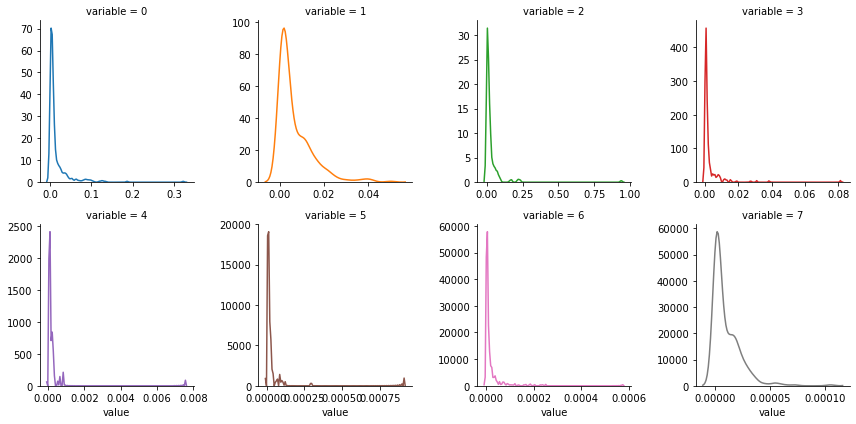

In [533]:
coefs_df = pd.DataFrame(np.vstack([x.flatten() if isinstance(x,np.ndarray) else numpy2ri.ri2py(x).flatten() for x in coefs])).melt()
coefs_df = coefs_df[coefs_df['value']>0]
sns.FacetGrid(coefs_df, col = 'variable', hue = 'variable', sharex=False, sharey=False, col_wrap=4).map(sns.kdeplot,'value')

In [536]:
coefs_df.groupby('variable').mean()

,value
variable,
0,0.015278
1,0.006694
2,0.027649
3,0.002742
4,0.000116
5,0.000016
6,0.000018
7,0.000010


In [598]:
mask = detection.get_mask(averaged_movie)
frame = averaged_movie[2800]
background_frame, signif_mask = detection.get_loc_background(frame)
frame = denoise_wavelet(frame, multichannel=False)
gls = [-ndimage.filters.gaussian_laplace(frame, sig) * sig **2 for sig in sigma_list]

if mask is None:
    mask = np.ones(np.shape(frame))
if filter_points:
    mask = mask * signif_mask

plm = [feature.peak_local_max(x, indices=False) for x in gls]
plm = [np.transpose(np.nonzero(x & mask))[::-1] for x in plm]
plmval = np.concatenate([[gls[i][r, c] for (r, c) in plm[i]] for i in range(len(sigma_list))])
sigmas_of_peaks = np.concatenate([np.repeat(sigma_list[i], len(plm[i])) for i in range(len(sigma_list))])
plm = np.hstack([np.concatenate(plm), sigmas_of_peaks.reshape(len(sigmas_of_peaks), 1)])

loc_background = np.array([background_frame[int(loc_max[0]), int(loc_max[1])] for loc_max in plm])
coef = detection.gev_glm(plmval, sigmas_of_peaks, loc_background)

In [600]:
coef

-0.000932,0.000073,0.000004,-0.000000,-0.000497,0.000067,0.000002,-0.000000


In [79]:
def gauss_laplace_fa(frame, sigma):
    window = math.ceil(4*sigma)
    fg = ndimage.gaussian_filter(frame, sigma)
    extended_frame = np.pad(frame, window, mode='reflect')

    x = np.arange(-window, window+1)
    gauss_1d = np.exp(-np.power(x,2)/(2.*sigma**2.))
    gx2 = gauss_1d*x**2
    
    imgLoG = (2*fg/sigma**2 - 
              (signal.convolve2d(gauss_1d*gx2.reshape(-1,1), extended_frame, 'valid') +
               signal.convolve2d(gx2*gauss_1d.reshape(-1,1), extended_frame, 'valid'))/sigma**4)
    imgLoG = imgLoG / (2*math.pi*sigma**2)
    return imgLoG

def gauss_laplace_scipy(frame, sigma):
    fg = ndimage.gaussian_filter(frame, sigma)
    imgLoG = ndimage.gaussian_laplace(fg, sigma)
    return imgLoG

(-0.5, 299.5, 299.5, -0.5)

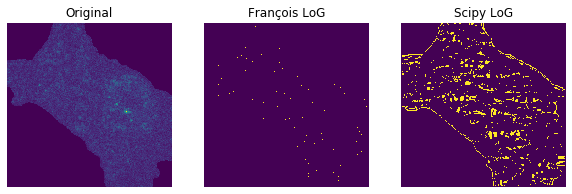

In [80]:
sigma = 3
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,15))
axs = axs.ravel()
axs[0].imshow(frame)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(feature.peak_local_max(-gauss_laplace_fa(frame,sigma), indices=False))
axs[1].set_title(u'François LoG')
axs[1].axis('off')
axs[2].imshow(feature.peak_local_max(-gauss_laplace_scipy(frame,sigma), indices=False))
axs[2].set_title('Scipy LoG')
axs[2].axis('off')

(-0.5, 299.5, 299.5, -0.5)

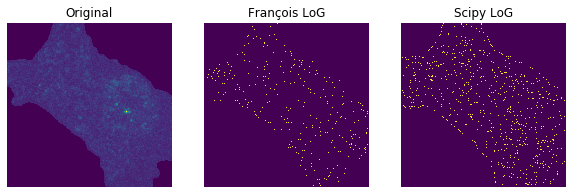

In [10]:
averaged_subset = ndimage.uniform_filter(movie_subset[:], size=(5,0,0))
masked_average = averaged_subset * mask
frame = masked_average[0]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,15))
axs = axs.ravel()
axs[0].imshow(frame)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(feature.peak_local_max(-gauss_laplace_fa(frame,sigma), indices=False))
axs[1].set_title(u'François LoG')
axs[1].axis('off')
axs[2].imshow(feature.peak_local_max(-gauss_laplace_scipy(frame,sigma), indices=False))
axs[2].set_title('Scipy LoG')
axs[2].axis('off')

In [473]:
st_time = time.time()
locs = detection.find_locs(averaged_subset, cutoff=0.9)
end_time = time.time() - st_time
events = tp.link_df(locs, search_range=1.5, memory=0)
events = tp.filter_stubs(events, 4)
puff_ids = np.array([detection.filter_df(events, m, 5) for m in markers_subset])
print(end_time)
report_performance(events, puff_ids, markers_subset)

Frame 299: 29 trajectories present.
49.80077791213989
6/6 puffs (6 unique) in 596 events (0.01007 freq)


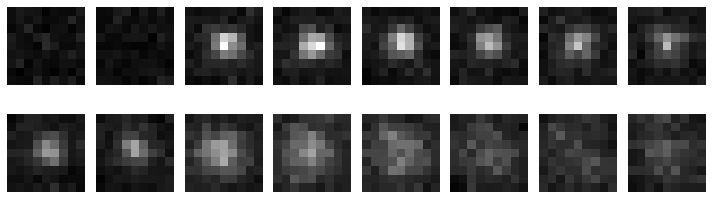

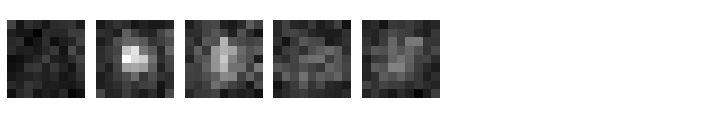

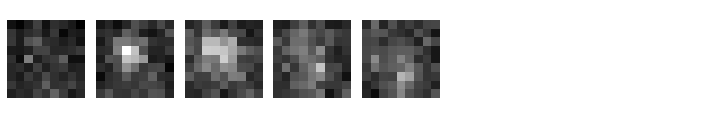

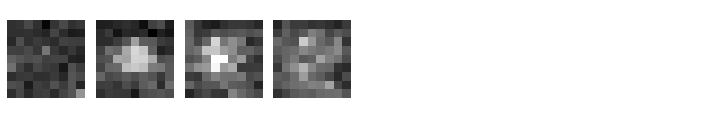

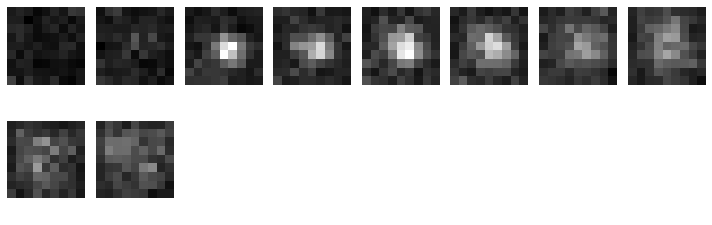

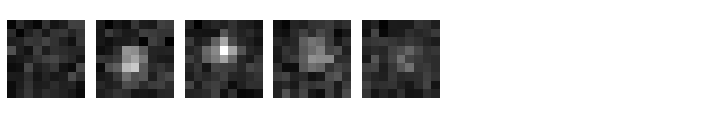

In [471]:
from lib import display
intensities = detection.intensity_grid(movie_subset, events)
for puff_id in puff_ids[puff_ids>0]:
    frames = display.get_frames(intensities.loc[intensities['particle'] == puff_id,:])
    fig, axs = display.plot_montage(frames)